In [1]:
#============================ Loading required libraries ============================#

import warnings
warnings.filterwarnings("ignore")

#!pip install datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
# import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset
import os

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-05-26 12:47:16.205681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748263636.414363      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748263636.476172      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#============================ Read Preprocessed Data ============================#

# For Kaggle, data is typically in /kaggle/input/
# Update this path according to your dataset name in Kaggle
try:
    # Try Kaggle input path first
    df = pd.read_csv('/kaggle/input/preprocessed-data/preprocessed_data.csv')
except:
    # Fallback to local path
    try:
        df = pd.read_csv('preprocessed_data.csv')
    except:
        print("Error: Could not find preprocessed_data.csv")
        print("Please ensure your dataset is uploaded to Kaggle or the file exists locally")
        raise FileNotFoundError("preprocessed_data.csv not found")

df['clean_tweet'] = df['clean_tweet'].astype(str)
df['tweet'] = df['tweet'].astype(str)

tweets = list(df['tweet'])
clean_tweets = list(df['clean_tweet'])
labels = list(df['label'])

print(f"Dataset loaded successfully with {len(df)} samples")
print(f"Label distribution: {df['label'].value_counts().to_dict()}")

Dataset loaded successfully with 24783 samples
Label distribution: {1: 20620, 0: 4163}


In [3]:
#============================ Tokenization ============================#

# Split into training, validation and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(clean_tweets, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Training samples: 15860
Validation samples: 3966
Test samples: 4957


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
#============================ Defining a PyTorch Dataset ============================#

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)


In [5]:
#============================ Loading the pre-trained Model ============================#

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Defining optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
#============================ Fine-tuning Model ============================#

print("Starting model training...")

for epoch in range(3):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_loss / num_batches
    
    # Validation loop
    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item() / labels.size(0)

    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')

Starting model training...
Epoch 1, Training Loss: 0.1514, Validation Accuracy: 0.9569
Epoch 2, Training Loss: 0.0927, Validation Accuracy: 0.9602
Epoch 3, Training Loss: 0.0658, Validation Accuracy: 0.9597


In [7]:
#============================ Evaluating Model Performance ============================#
print("Evaluating model on test set...")

true_labels = []
predicted_labels = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

Evaluating model on test set...


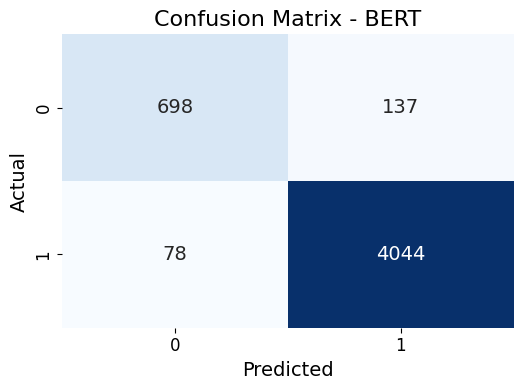


Classification Report:

                precision    recall  f1-score   support

  Appropriate       0.90      0.84      0.87       835
Inappropriate       0.97      0.98      0.97      4122

     accuracy                           0.96      4957
    macro avg       0.93      0.91      0.92      4957
 weighted avg       0.96      0.96      0.96      4957


Evaluation Metrics:

Accuracy: 0.9566269921323381
Precision: 0.9672327194451088
Recall: 0.9810771470160117
F1-score: 0.9741057449114777


In [8]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - BERT', fontsize = 16)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


# Classification report
target_names = ['Appropriate', 'Inappropriate']
print('\nClassification Report:\n\n', classification_report(true_labels, predicted_labels, target_names=target_names))

# Evaluation Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [9]:
#============================ Save the model ============================#

# Create output directory for Kaggle
os.makedirs('/kaggle/working/bert_model', exist_ok=True)

# Save the model and tokenizer
model.save_pretrained('/kaggle/working/bert_model/')
tokenizer.save_pretrained('/kaggle/working/bert_model/')

print("Model saved successfully to /kaggle/working/bert_model/")

# Also save a summary of results
results_summary = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'confusion_matrix': cm.tolist()
}

import json
with open('/kaggle/working/model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved to /kaggle/working/model_results.json")

Model saved successfully to /kaggle/working/bert_model/
Results summary saved to /kaggle/working/model_results.json


In [10]:
#============================ Text Preprocessing Functions ============================#

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)
    return text

# Removing URLs
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»""'']))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("?", '')
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

# Removing stopwords
def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]

    return clean



In [11]:
#============================ Prediction Example ============================#

print("\n" + "="*50)
print("Testing model with sample prediction...")

# Load the saved model for prediction
saved_model = BertForSequenceClassification.from_pretrained('/kaggle/working/bert_model/')
saved_tokenizer = BertTokenizer.from_pretrained('/kaggle/working/bert_model/')
saved_model.to(device)
saved_model.eval()

custom_input_text = "Kill Yourself!!"
print(f"Input text: '{custom_input_text}'")

custom_text_list = [custom_input_text]
preprocessed_custom_text = preprocess(custom_text_list)[0]
print(f"Preprocessed text: '{preprocessed_custom_text}'")

tokenized_input = saved_tokenizer(preprocessed_custom_text, return_tensors='pt').to(device)
with torch.no_grad():
    output = saved_model(**tokenized_input)
    logits = output.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).item()

probability_class_0 = probabilities[0][0].item()
probability_class_1 = probabilities[0][1].item()

print(f"Predicted Label: {predicted_label}")
print(f"Probability for Class 0 (Appropriate): {probability_class_0:.4f}")
print(f"Probability for Class 1 (Inappropriate): {probability_class_1:.4f}")

label_names = ['Appropriate', 'Inappropriate']
print(f"Prediction: {label_names[predicted_label]}")

print("\n" + "="*50)
print("Training and evaluation completed successfully!")
print("Model files saved to /kaggle/working/bert_model/")
print("You can download the model from the Kaggle output section.")


Testing model with sample prediction...
Input text: 'Kill Yourself!!'
Preprocessed text: 'kill'
Predicted Label: 1
Probability for Class 0 (Appropriate): 0.4390
Probability for Class 1 (Inappropriate): 0.5610
Prediction: Inappropriate

Training and evaluation completed successfully!
Model files saved to /kaggle/working/bert_model/
You can download the model from the Kaggle output section.
